In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn.linear_model import LinearRegression
from matplotlib.patches import Circle
from matplotlib import cm, colors

# Set font sizes for plots
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=MEDIUM_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('font', size=MEDIUM_SIZE)

# Global warming levels
Tglob = ["T0","T15","T27"]
Tglob_values = [0,1.5,2.7]

# Data path
data_path = '/work/uo1075/u241297/data/large_ensembles/CMIP6/'

# Global warming levels

In [2]:
path=data_path+'MPI-ESM1-2-LR/global-mean/'

# Load global-mean surface air temperature (GSAT) data
GSAT = np.zeros((50, 251))
for i in range(50):
    file = path + "tas_hist_ssp585_r" + str(i + 1) + "_global-mean.nc"
    GSAT[i, :] = np.squeeze(xr.open_dataset(file)['tas']) - 273.15

GSAT_rm = np.array(pd.DataFrame(GSAT).rolling(20, axis=1, center=True).mean())
Tzero_GSAT = np.mean(GSAT[:, 0:51])  # 1850-1900
GSATa = GSAT - Tzero_GSAT
GSATa_rm = GSAT_rm - Tzero_GSAT

In [3]:
# Determine the indices where GSAT crosses the global warming levels
GWLcross_ind = {T: np.empty(50, dtype=int) for T in Tglob}
GWLcross_ind["T0"] = 50 * [20]

for T in range(1, 3):
    for i in range(50):
        j = 20
        while GSATa_rm[i, j] < Tglob_values[T]:
            j += 1
        GWLcross_ind[Tglob[T]][i] = j

GWL_ind = {T: np.zeros((50, 20), dtype=int) for T in Tglob}

for T in range(3):
    for i in range(50):
        GWL_ind[Tglob[T]][i, :] = np.arange(GWLcross_ind[Tglob[T]][i] - 10, GWLcross_ind[Tglob[T]][i] + 10)

# Sea ice area

In [4]:
# Load Sea Ice Area (SIA) data
path=data_path+'MPI-ESM1-2-LR/sia_nh/'
    
SIA = np.zeros((50,251,12))
for i in range(50):
    file = path+"sia_nh_MPI-ESM1-2-LR_r"+str(i+1)+"i1p1f1.nc"
    SIA[i,:] = np.array(xr.open_dataset(file)['sia_nh']).reshape((251,12))

# Create GWL samples of September and March SIA
SIA_sep_samples = {Tglob[T]: [SIA[i, GWL_ind[Tglob[T]][i, :], 8] for i in range(50)] for T in range(3)}
SIA_mar_samples = {Tglob[T]: [SIA[i, GWL_ind[Tglob[T]][i, :], 2] for i in range(50)] for T in range(3)}

## Bias correction (based on Niederdrenk and Notz, 2018)

In [5]:
# Observational regression parameters (Niederdrenk and Notz, 2018)
slope_obs_sep, intercept_obs_sep = -4.1, 7.97
slope_obs_mar, intercept_obs_mar = -1.6, 15.08

# Model regression line
GSATa_ensmean = np.mean(GSATa, axis=0)
SIA_sep_ensmean = np.mean(SIA[:, :, 8], axis=0)
SIA_mar_ensmean = np.mean(SIA[:, :, 2], axis=0)

model_sep = LinearRegression().fit(GSATa_ensmean[103:167].reshape((-1, 1)), SIA_sep_ensmean[103:167])
model_mar = LinearRegression().fit(GSATa_ensmean[103:167].reshape((-1, 1)), SIA_mar_ensmean[103:167])

# Bias correction function
def bias_correction(SIA, model, slope_obs, intercept_obs, GSATa):
    correction = intercept_obs - model.intercept_ + (slope_obs - model.coef_[0]) * GSATa
    corrected_SIA = SIA + correction #[:, np.newaxis]
    corrected_SIA[corrected_SIA < 0] = 0
    return corrected_SIA

# Apply bias correction for September and March
SIA_sep_corr = bias_correction(SIA[:, :, 8], model_sep, slope_obs_sep, intercept_obs_sep, GSATa)
SIA_mar_corr = bias_correction(SIA[:, :, 2], model_mar, slope_obs_mar, intercept_obs_mar, GSATa)

# Bias corrected samples for September and March
SIA_sep_corr_samples = {
    Tglob[T]: [SIA_sep_corr[i, GWL_ind[Tglob[T]][i, :]] for i in range(50)]
    for T in range(3)
}

SIA_mar_corr_samples = {
    Tglob[T]: [SIA_mar_corr[i, GWL_ind[Tglob[T]][i, :]] for i in range(50)]
    for T in range(3)
}

In [6]:
# Define a function for detrending by subtraction of ensemble mean
def detrend_samples(samples, Tglob):
    ensmean_samples = {T: np.mean(samples[T], axis=0) for T in Tglob}
    detrend_samples = {
        T: samples[T] - ensmean_samples[T][np.newaxis, :] + np.mean(ensmean_samples[T])
        for T in Tglob
    }
    for T in Tglob:
        detrend_samples[T][detrend_samples[T] < 0] = 0
    return detrend_samples

# Detrend by ensemble mean
SIA_sep_corr_detrend_samples = detrend_samples(SIA_sep_corr_samples, Tglob)
SIA_mar_corr_detrend_samples = detrend_samples(SIA_mar_corr_samples, Tglob)

## Circle plots

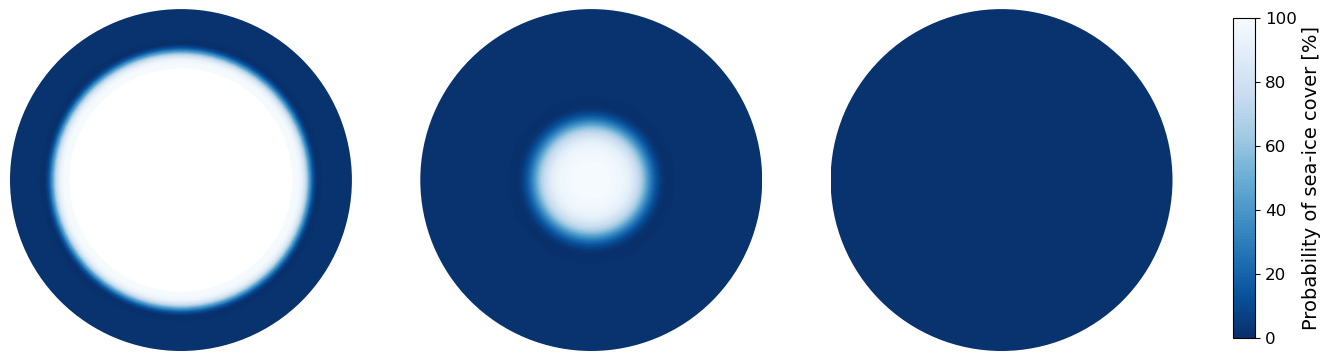

In [7]:
# Constants
AO_area = 14.06
center = (0.5, 0.5)
radius_AO = 0.5

# Load the colormap
cmap = cm.get_cmap('Blues', 101)

# Create subplots
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Loop over the three GWLs
for T in range(3):
    # Draw outer circle
    circle_AO = Circle(center, radius_AO, fc=cmap(0.99))
    ax[T].add_patch(circle_AO)
    
    # Draw sea ice area circles
    for perc in range(100, -1, -1):
        radius_SIA = radius_AO * math.sqrt(np.percentile(SIA_sep_corr_detrend_samples[Tglob[T]], perc) / AO_area)
        circle_SIA = Circle(center, radius_SIA, fc=cmap(perc / 100))
        ax[T].add_patch(circle_SIA)
    
    # Draw inner white circle at minimum SIA
    circle_SIA = Circle(center, radius_SIA, fc='white')
    ax[T].add_patch(circle_SIA)
    
    ax[T].set_aspect('equal')
    ax[T].axis('off')

# Add a colorbar
cax = fig.add_axes([0.94, 0.18, 0.015, 0.64])
norm = colors.Normalize(vmin=0, vmax=100)
sm = plt.cm.ScalarMappable(cmap=cmap.reversed(), norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label('Probability of sea-ice cover [%]')

plt.show()